# Non-stationary SCM and DAG (NONSTAT.) from figure 3(c) in paper

In [296]:
import sys
import os

# Get the absolute path of the notebooks directory
current_dir = os.path.abspath(os.path.dirname('__file__'))

# Get the parent directory (DCBO-master)
parent_dir = os.path.dirname(current_dir)

print("Current directory:", current_dir)
print("Parent directory:", parent_dir)

# Add the parent directory to Python path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

Current directory: C:\Users\EMRE\Desktop\JpMorgan_Paper\3\Part 1\DCBO-master\DCBO-master\notebooks
Parent directory: C:\Users\EMRE\Desktop\JpMorgan_Paper\3\Part 1\DCBO-master\DCBO-master


In [298]:
%load_ext autoreload
%autoreload 2

from dcbo.examples.example_setups import setup_nonstat_scm
from dcbo.utils.sem_utils.toy_sems import NonStationaryDependentSEM as NonStatSEM
from dcbo.utils.sem_utils.sem_estimate import build_sem_hat
from dcbo.experimental.experiments import run_methods_replicates
from dcbo.utils.sequential_sampling import sequentially_sample_model
from dcbo.utils.plotting import plot_outcome

from dcbo.methods.dcbo import DCBO

from numpy.random import seed
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem setup

C:\Users\EMRE\Desktop\JpMorgan_Paper\3\Part 1\DCBO-master\DCBO-master\dcbo\utils\sem_utils\toy_sems.py:180: RuntimeWarning: invalid value encountered in scalar divide
  lambda e, t, s: -s["X"][t] / s["X"][t - 1] + s["Z"][t - 1] + e


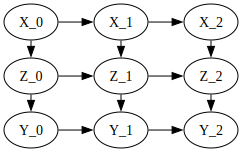

In [300]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, all_causal_effects  = setup_nonstat_scm(T=T)
dag_view

Unlike the DAG used for the STAT. example (figure 1 in paper) we need to modify the structure of this DAG to represent the non-stationary evolution of the SEM used in the example.

In [302]:
# Simple networkx syntax is used to manipulate an object
G.add_edge('X_0','Z_1')
G.add_edge('Z_1','Y_2')

# We print out the edge set just to make sure they have been properly added
G.edges

OutMultiEdgeView([('X_0', 'Z_0', 0), ('X_0', 'X_1', 0), ('X_0', 'Z_1', 0), ('Z_0', 'Y_0', 0), ('Z_0', 'Z_1', 0), ('Y_0', 'Y_1', 0), ('X_1', 'Z_1', 0), ('X_1', 'X_2', 0), ('Z_1', 'Y_1', 0), ('Z_1', 'Z_2', 0), ('Z_1', 'Y_2', 0), ('Y_1', 'Y_2', 0), ('X_2', 'Z_2', 0), ('Z_2', 'Y_2', 0)])

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [304]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [306]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }



**OBS. that the `dag_view` will not show our added edges as the object was generated before we modified the topology**

Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

## Other setup parameters 

In [311]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = 4.317', 'y^*_1 = -8.329', 'y^*_2 = 12.387']


# Dynamic causal Bayesian optimisation

In [320]:
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=10, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
DCBO_input_params = {
    "G": G,
    "sem": NonStatSEM,
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "debug_mode":False,
    "ground_truth":all_causal_effects,
    "change_points": change_points,
}

dcbo = DCBO(**DCBO_input_params)
dcbo.run()

[autoreload of dcbo.bases.root failed: Traceback (most recent call last):
  File "C:\Users\EMRE\AppData\Local\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\EMRE\AppData\Local\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\EMRE\AppData\Local\anaconda3\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\EMRE\Desktop\JpMorgan_Paper\3\Part 1\DCBO-master\DCBO-master\dcbo\bases\root.py", line 5, in <module>
    from .utils.gp_utils import update_sufficient_statistics, update_sufficient_statistics_hat
ModuleNotFoundError: No modu

TypeError: update_sufficient_statistics_hat() missing 3 required positional arguments: 'static_sem', 'dynamic_sem', and 'timesteps'

In [ ]:
plot_outcome(T,N,outcomes=[dcbo.optimal_outcome_values_during_trials],labels=['DCBO'],true_objective_values=true_objective_values)

## Explore all optimization methods with one function

Unlike the demo in `stat_scm.ipynb` here we are going to demonstrate the replicate method as used to generate the results in the paper. In all these examples we do not employ any interventional data, just observational.

In [18]:
# See method for argument details
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
R = 3
results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=True,
                                change_points=change_points)

Experiment count:   0%|          | 0/3 [00:00<?, ?it/s]


	>>>DCBO



 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:26<00:00,  9.00s/it]



	>>>CBO



reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters G


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]



	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count:  33%|███▎      | 1/3 [01:06<02:12, 66.35s/it]


	>>>DCBO



 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:29<0


	>>>CBO



reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters G


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]



	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count:  67%|██████▋   | 2/3 [02:17<01:08, 68.98s/it]


	>>>DCBO



 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:27<0


	>>>CBO



reconstraining parameters GP_regression.rbf.variance
 /Users/nd/cloud/turing/DCBO/src/utils/sem_utils/toy_sems.py:181: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters G


	>>>ABO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]



	>>>BO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Experiment count: 100%|██████████| 3/3 [03:25<00:00, 68.53s/it]


## Analyse results and plot

In [19]:
from src.experimental.analyse_results import get_relevant_results, elaborate
from src.utils.plotting import plot_expected_opt_curve_paper
from matplotlib.pyplot import rc

In [20]:
# Since we didn't save the results we cannot use the pickled file so we have to convert results to the correct format
data = get_relevant_results(results=results,replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

### Plot results

In [21]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCBO': 'DCBO', 'CBO': 'CBO', 'ABO': 'ABO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCBO': 'blue', 'CBO': 'green', 'ABO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCBO': '-', 'CBO': '--', 'ABO': 'dashdot', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

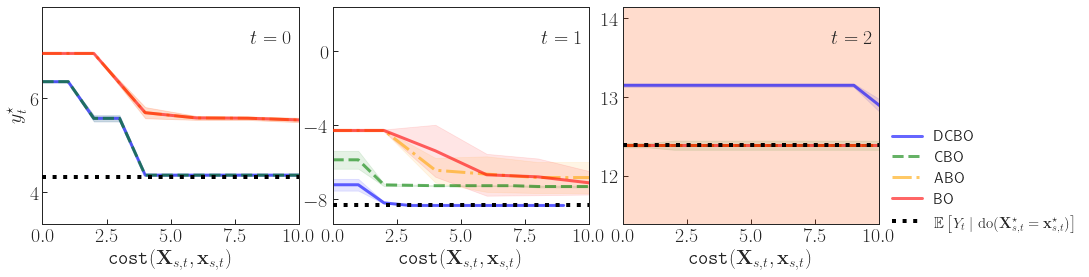

In [22]:
# Here we demonstrate how to use the plot functionality as used in the paper. Each frame corresponds to one time-slice. As we have only run each model for ten trials, we do not expect stellar results (see final frame).
plot_expected_opt_curve_paper(T,
    true_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,4))